1. Number of Distinct Orders Each Month (Time-Series Model)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Load the dataset
file_path = "c:/Users/nazil/Downloads/data_set_hackathon.csv"  # Update with the correct path
data = pd.read_csv(file_path)

In [4]:
print(data.head())

   order_date requested_delivery_date Customer Country Code Product Code  \
0  13.07.2009              28.01.2010                    RU    L10705000   
1  15.07.2009              24.03.2010                    RU    L10705000   
2  16.07.2009              04.02.2010                    RU    L10705000   
3  17.07.2009              04.02.2010                    RU    L10705000   
4  21.07.2009              01.02.2010                    RU    L10705000   

                   Description order_type  Customer Order Code     value Curr  \
0  Parka Outdoor Lifestyle STD         VO           3200435553   2337.00  RUB   
1  Parka Outdoor Lifestyle STD         VO           3200435694  10160.25  RUB   
2  Parka Outdoor Lifestyle STD         VO           3200435741   2992.50  RUB   
3  Parka Outdoor Lifestyle STD         VO           3200435907   4061.25  RUB   
4  Parka Outdoor Lifestyle STD         VO           3200435963   2208.75  RUB   

  items   Route  
0     6  RU0001  
1    23  RU0001  
2 

In [5]:
data.describe()

,Customer Order Code,value
count,2.420000e+03,2420.000000
mean,3.200672e+09,1162.976624
std,1.004408e+05,2560.595118
min,3.200435e+09,-0.030000
25%,3.200614e+09,33.030000
50%,3.200711e+09,70.490000
75%,3.200729e+09,1363.200000
max,3.201062e+09,38937.500000


In [6]:
# Check for missing values in the entire dataset
missing_values = data.isnull().sum()

# Display columns with missing values
print(missing_values[missing_values > 0])

Series([], dtype: int64)


In [7]:
data['items'] = data['items'].fillna(0)

In [8]:
# Replace '\\N' with NaN in the dataset to handle invalid values
data.replace('\\N', pd.NA, inplace=True)

In [9]:
# Prepare data
data['order_date'] = pd.to_datetime(data['order_date'], format='%d.%m.%Y')
data['Year-Month'] = data['order_date'].dt.to_period('M')
monthly_orders = data.groupby('Year-Month')['Customer Order Code'].nunique()

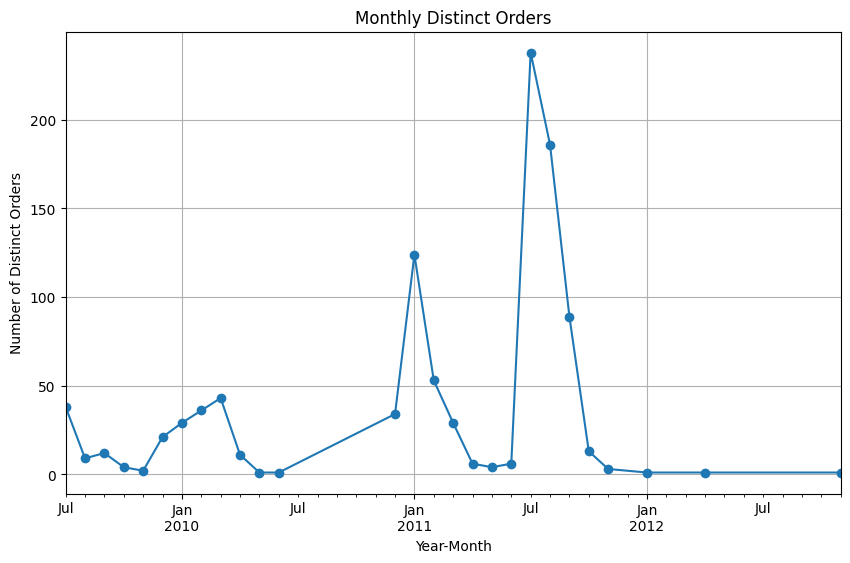

In [10]:
# Visualize monthly distinct orders
plt.figure(figsize=(10, 6))
monthly_orders.plot(kind='line', marker='o', title='Monthly Distinct Orders')
plt.xlabel('Year-Month')
plt.ylabel('Number of Distinct Orders')
plt.grid()
plt.show()

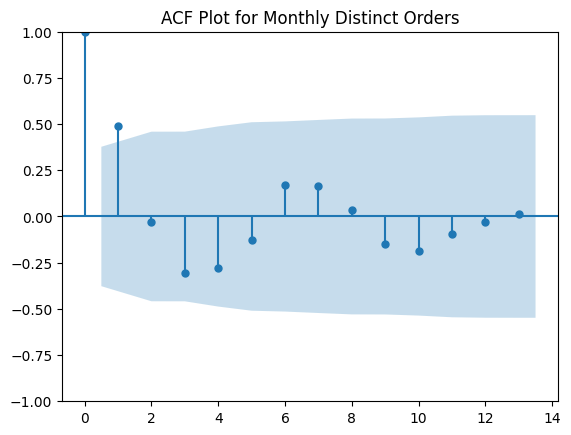

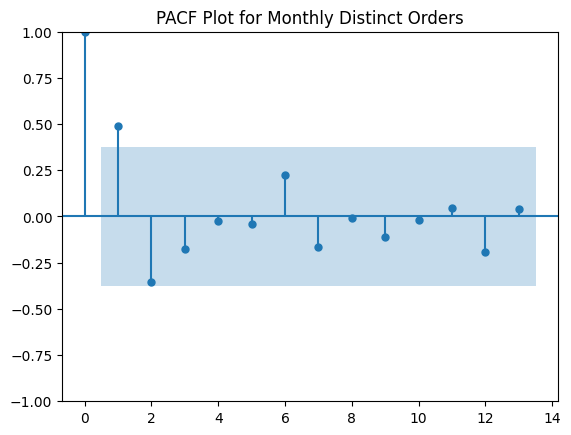

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
plot_acf(monthly_orders)
plt.title('ACF Plot for Monthly Distinct Orders')
plt.show()

plot_pacf(monthly_orders)
plt.title('PACF Plot for Monthly Distinct Orders')
plt.show()

In [13]:
from statsmodels.tsa.arima.model import ARIMA

In [14]:
# Fit the ARIMA model
model = ARIMA(monthly_orders, order=(2, 1, 2))
model_fit = model.fit()

print(model_fit.summary())

c:\Users\nazil\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                SARIMAX Results                                
Dep. Variable:     Customer Order Code   No. Observations:                   27
Model:                  ARIMA(2, 1, 2)   Log Likelihood                -138.646
Date:                 Sun, 08 Dec 2024   AIC                            287.292
Time:                         00:49:29   BIC                            293.582
Sample:                     07-31-2009   HQIC                           289.103
                          - 11-30-2012                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9403      2.584      0.364      0.716      -4.124       6.005
ar.L2         -0.4634      1.338     -0.346      0.729      -3.087       2.160
ma.L1         -1.3058      3.789     -0.345 

In [15]:
# Forecast for the next 5 months
forecast = model_fit.get_forecast(steps=5)
forecast_ci = forecast.conf_int()  # Confidence intervals

# Replace negative lower bounds with 0
forecast_ci[forecast_ci < 0] = 0

In [16]:
# Get the forecasted months (skip the last month of historical data)
forecast_months = pd.date_range(
    start=monthly_orders.index[-1].end_time,  # Use the end of the last known period
    periods=6,  # periods=6 to include the first forecast month
    freq='M')[1:]  # Skip the first forecasted month (it's the last historical month)

C:\Users\nazil\AppData\Local\Temp\ipykernel_13104\1117180234.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_months = pd.date_range(


In [17]:
# Assign the forecasted values and confidence intervals to the forecast months
forecasted_values = forecast.predicted_mean
lower_bound = forecast_ci.iloc[:, 0]
upper_bound = forecast_ci.iloc[:, 1]

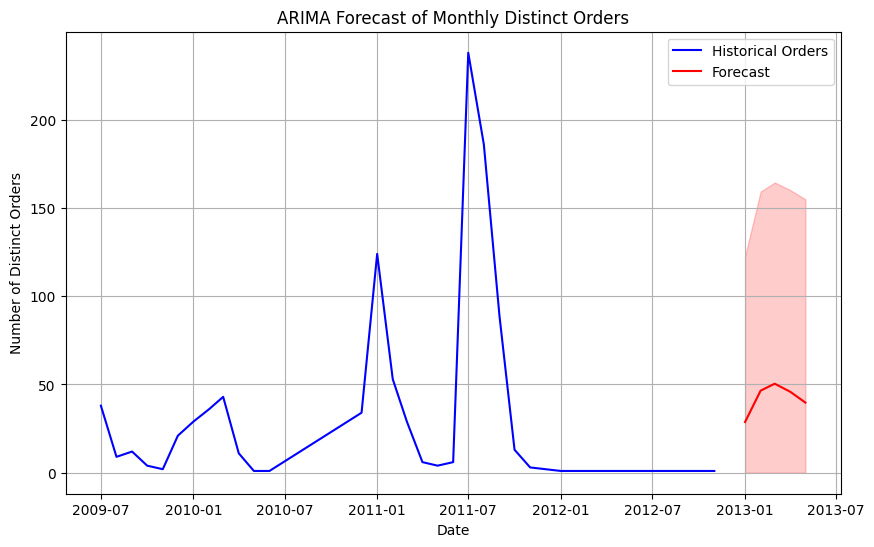

In [18]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(monthly_orders.index.to_timestamp(), monthly_orders, label='Historical Orders', color='blue')
plt.plot(forecast_months, forecasted_values, label='Forecast', color='red')

# Plot the confidence intervals
plt.fill_between(forecast_months, lower_bound, upper_bound, color='red', alpha=0.2)

# Add labels and legend
plt.legend()
plt.title("ARIMA Forecast of Monthly Distinct Orders")
plt.xlabel("Date")
plt.ylabel("Number of Distinct Orders")
plt.grid(True)

# Show plot
plt.show()

In [19]:
# Print forecasted values and confidence intervals
print("Forecasted Values:")
print(forecasted_values)
print("\nConfidence Intervals:")
print(forecast_ci)

Forecasted Values:
2011-10    28.711134
2011-11    46.524223
2011-12    50.431694
2012-01    45.851040
2012-02    39.733271
Freq: M, Name: predicted_mean, dtype: float64

Confidence Intervals:
         lower Customer Order Code  upper Customer Order Code
2011-10                        0.0                 122.651536
2011-11                        0.0                 159.320974
2011-12                        0.0                 164.465386
2012-01                        0.0                 160.159437
2012-02                        0.0                 154.912641


Sarima

In [23]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

c:\Users\nazil\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\nazil\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\nazil\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                     SARIMAX Results                                      
Dep. Variable:                Customer Order Code   No. Observations:                   27
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 -79.813
Date:                            Sun, 08 Dec 2024   AIC                            167.625
Time:                                    00:52:44   BIC                            170.181
Sample:                                07-31-2009   HQIC                           167.388
                                     - 11-30-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5615      1.212      0.463      0.643      -1.814       2.936
ma.L1         -0.9986    140.155   

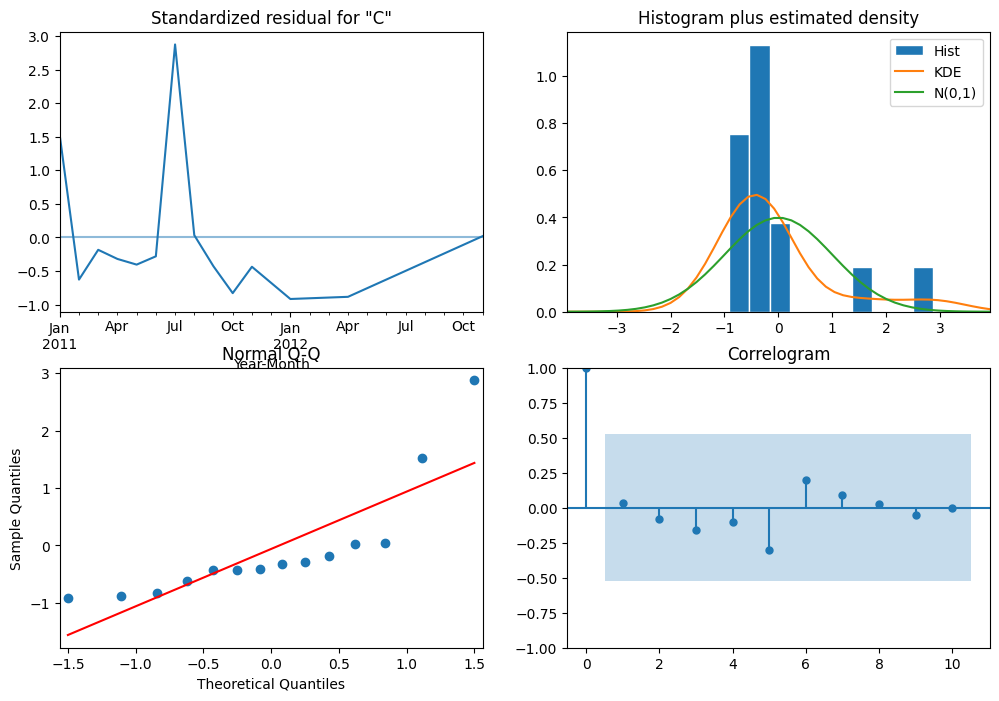

In [24]:
# Define the SARIMA model with simpler parameters (ARIMA(1, 1, 1) with seasonality)
model = SARIMAX(monthly_orders, order=(1, 1, 1), seasonal_order=(0, 1, 1, 12))

# Fit the model
model_fit = model.fit(disp=False)

# Print the model summary
print(model_fit.summary())

# Plot diagnostics
model_fit.plot_diagnostics(figsize=(12, 8))
plt.show()


AIC: 167.625045323699, BIC: 170.18127464216002


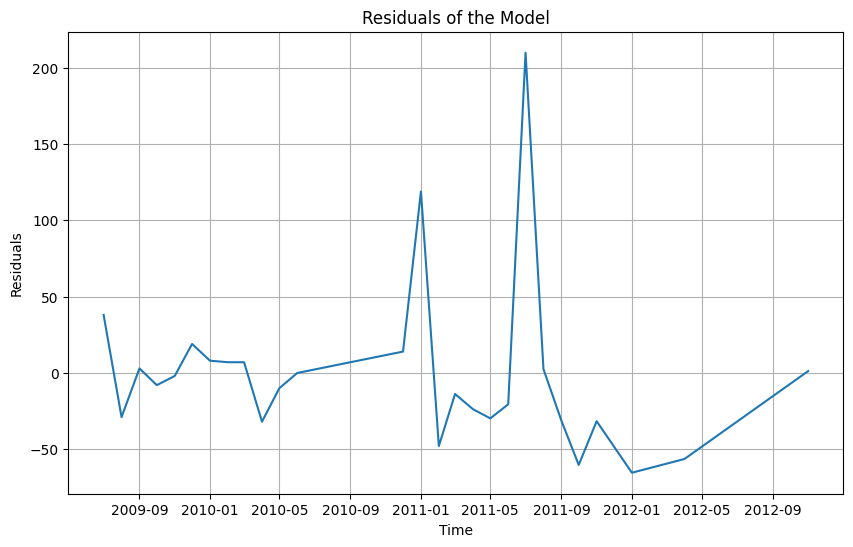

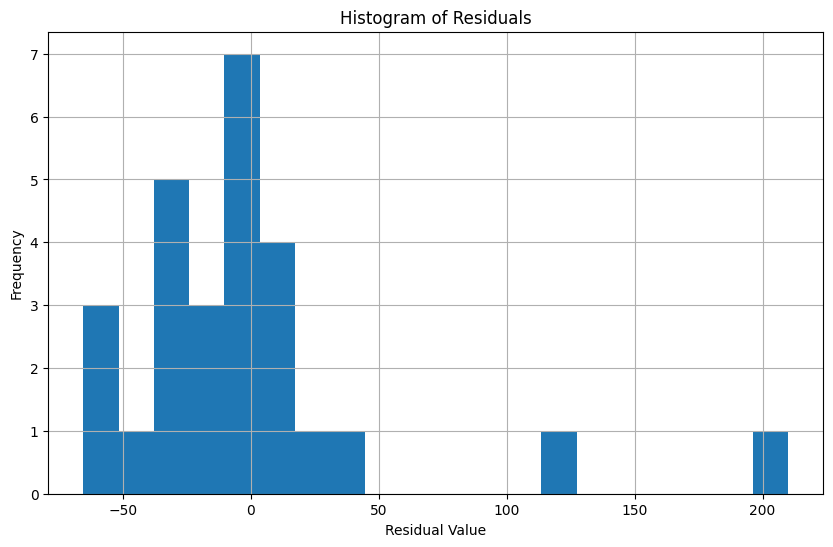

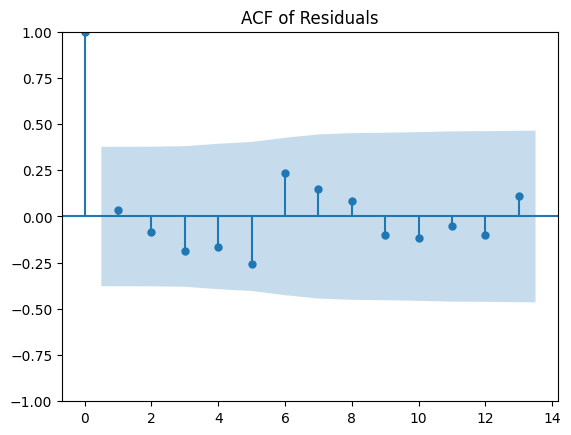

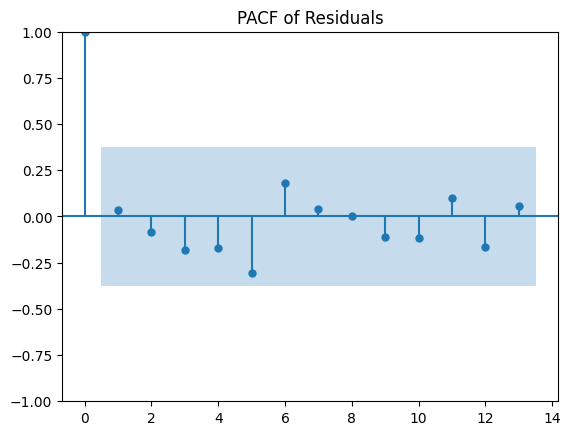

In [26]:
# Extract AIC and BIC for model comparison
aic = model_fit.aic
bic = model_fit.bic

print(f"AIC: {aic}, BIC: {bic}")

# Check residuals
residuals = model_fit.resid

# Convert PeriodIndex to DatetimeIndex for plotting
residuals.index = residuals.index.to_timestamp()

# Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title("Residuals of the Model")
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.grid()
plt.show()

# Histogram of residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=20)
plt.title("Histogram of Residuals")
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.grid()
plt.show()

# Check for autocorrelation of residuals
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(residuals)
plt.title("ACF of Residuals")
plt.show()

plot_pacf(residuals)
plt.title("PACF of Residuals")
plt.show()

C:\Users\nazil\AppData\Local\Temp\ipykernel_13104\3428243339.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=monthly_orders.index[-1], periods=6, freq='M')[1:]


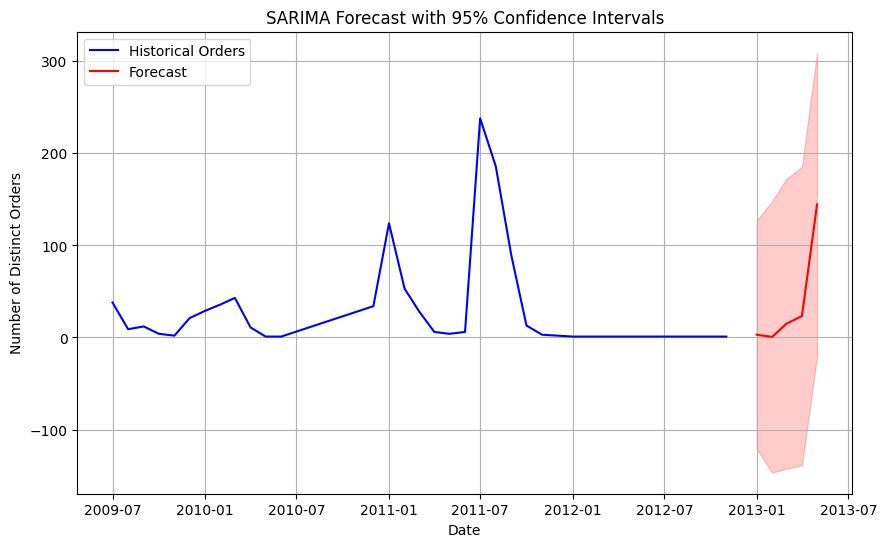

Forecasted Values:
2011-10      3.013840
2011-11      0.670399
2011-12     14.908847
2012-01     23.245457
2012-02    144.572168
Freq: M, Name: predicted_mean, dtype: float64

Confidence Intervals:
         lower Customer Order Code  upper Customer Order Code
2011-10                -120.668355                 126.696034
2011-11                -146.860215                 148.201013
2011-12                -142.412584                 172.230278
2012-01                -138.805521                 185.296434
2012-02                 -20.121457                 309.265793


In [29]:
# Ensure monthly_orders.index is converted to DatetimeIndex
monthly_orders.index = monthly_orders.index.to_timestamp()

# Forecast the next 5 months
forecast = model_fit.get_forecast(steps=5)
forecast_ci = forecast.conf_int()

# Convert the forecast index to DatetimeIndex
forecast_index = pd.date_range(start=monthly_orders.index[-1], periods=6, freq='M')[1:]

# Plot the forecast along with the confidence intervals
plt.figure(figsize=(10, 6))
plt.plot(monthly_orders.index, monthly_orders, label='Historical Orders', color='blue')
plt.plot(forecast_index, forecast.predicted_mean, label='Forecast', color='red')
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='red', alpha=0.2)

plt.title("SARIMA Forecast with 95% Confidence Intervals")
plt.xlabel("Date")
plt.ylabel("Number of Distinct Orders")
plt.legend()
plt.grid(True)
plt.show()

# Print forecast values and confidence intervals
print("Forecasted Values:")
print(forecast.predicted_mean)
print("\nConfidence Intervals:")
print(forecast_ci)

c:\Users\nazil\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nazil\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nazil\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\nazil\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting 

                                      SARIMAX Results                                       
Dep. Variable:                  Customer Order Code   No. Observations:                   27
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 12)   Log Likelihood                 -79.431
Date:                              Sun, 08 Dec 2024   AIC                            170.862
Time:                                      01:06:21   BIC                            174.696
Sample:                                           0   HQIC                           170.507
                                               - 27                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4989     10.798      0.139      0.890     -19.665      22.663
ar.L2         -0.68

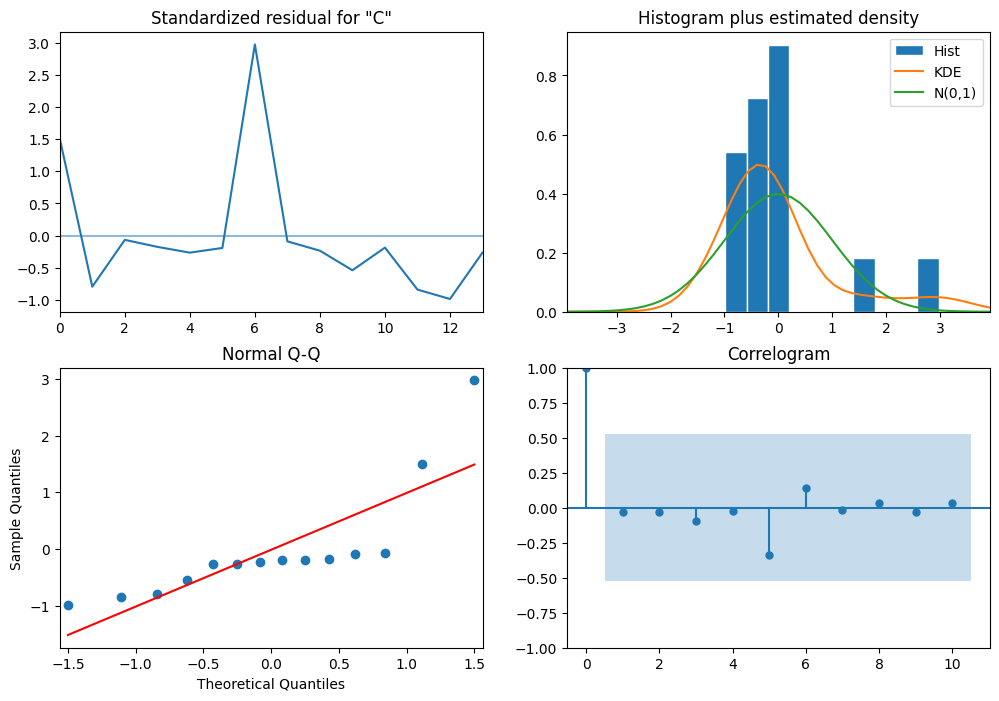

c:\Users\nazil\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\nazil\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


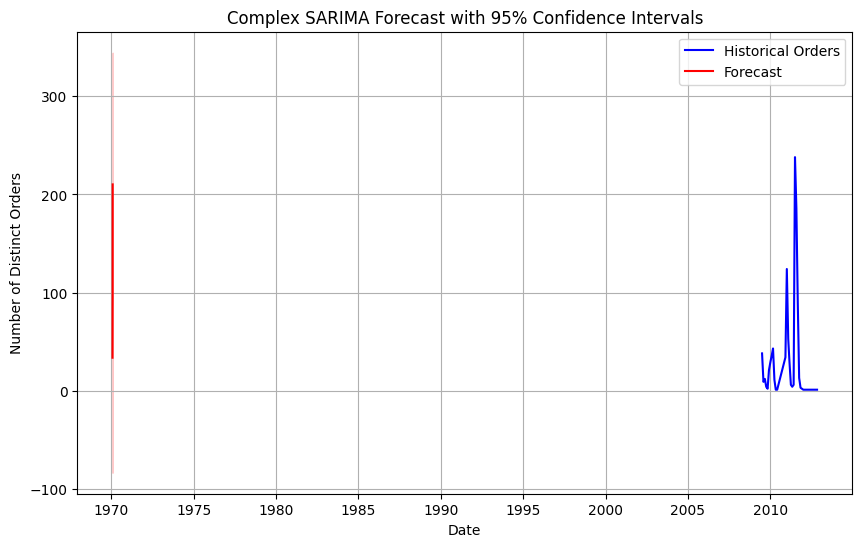

In [30]:
# For example, using (2, 1, 2)x(0, 1, 1, 12) as a more complex model
model_complex = SARIMAX(monthly_orders, order=(2, 1, 2), seasonal_order=(0, 1, 1, 12))
model_complex_fit = model_complex.fit(disp=False)

# Print summary of the complex model
print(model_complex_fit.summary())

# Plot diagnostics for the complex model
model_complex_fit.plot_diagnostics(figsize=(12, 8))
plt.show()

# Forecast the next 5 months using the more complex model
forecast_complex = model_complex_fit.get_forecast(steps=5)
forecast_complex_ci = forecast_complex.conf_int()

# Plot the forecast along with the confidence intervals
plt.figure(figsize=(10, 6))
plt.plot(monthly_orders.index, monthly_orders, label='Historical Orders', color='blue')
plt.plot(forecast_complex.predicted_mean.index, forecast_complex.predicted_mean, label='Forecast', color='red')
plt.fill_between(forecast_complex_ci.index, forecast_complex_ci.iloc[:, 0], forecast_complex_ci.iloc[:, 1], color='red', alpha=0.2)

plt.title("Complex SARIMA Forecast with 95% Confidence Intervals")
plt.xlabel("Date")
plt.ylabel("Number of Distinct Orders")
plt.legend()
plt.grid(True)
plt.show()


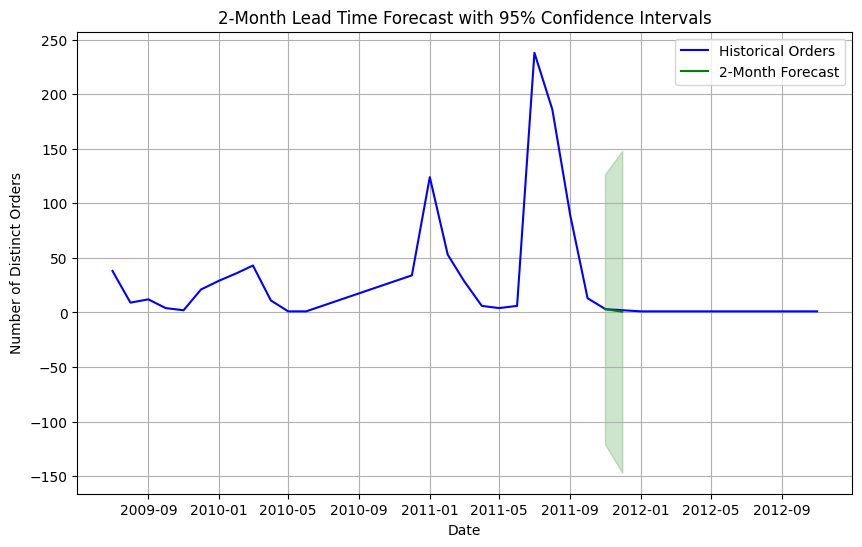

2-Month Lead Time Forecasted Values:
2011-10    3.013840
2011-11    0.670399
Freq: M, Name: predicted_mean, dtype: float64

2-Month Lead Time Confidence Intervals:
         lower Customer Order Code  upper Customer Order Code
2011-10                -120.668355                 126.696034
2011-11                -146.860215                 148.201013


In [32]:
# Forecast the next 2 months (assuming lead time is reduced)
forecast_2_months = model_fit.get_forecast(steps=2)
forecast_2_months_ci = forecast_2_months.conf_int()

# Plot the forecasted values along with the confidence intervals
plt.figure(figsize=(10, 6))
plt.plot(monthly_orders.index, monthly_orders, label='Historical Orders', color='blue')
plt.plot(forecast_2_months.predicted_mean.index, forecast_2_months.predicted_mean, label='2-Month Forecast', color='green')
plt.fill_between(forecast_2_months_ci.index, forecast_2_months_ci.iloc[:, 0], forecast_2_months_ci.iloc[:, 1], color='green', alpha=0.2)

plt.title("2-Month Lead Time Forecast with 95% Confidence Intervals")
plt.xlabel("Date")
plt.ylabel("Number of Distinct Orders")
plt.legend()
plt.grid(True)
plt.show()

# Print forecasted values and confidence intervals for 2-month lead time
print("2-Month Lead Time Forecasted Values:")
print(forecast_2_months.predicted_mean)
print("\n2-Month Lead Time Confidence Intervals:")
print(forecast_2_months_ci)


In [31]:
from sklearn.metrics import mean_absolute_percentage_error

# Actual values for comparison (from test set)
actual_values = # actual test data corresponding to forecast period (make sure to have the data)
forecast_values = forecast.predicted_mean

# Calculate MAPE
mape = mean_absolute_percentage_error(actual_values, forecast_values)
print(f"MAPE: {mape:.2f}%")


SyntaxError: invalid syntax (1833678310.py, line 4)

2. Which Items Are Demanded (Classification Model)

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.pipeline import Pipeline as imPipeline
from sklearn.impute import SimpleImputer

In [18]:
data['Season'] = data['order_date'].dt.month.map(lambda x: 'Winter' if x in [12, 1, 2] else
                                                 'Spring' if x in [3, 4, 5] else
                                                 'Summer' if x in [6, 7, 8] else 'Autumn')

In [19]:
# One-hot encode the 'Season' categorical variable
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_season = encoder.fit_transform(data[['Season']])
season_encoded_df = pd.DataFrame(encoded_season, columns=encoder.get_feature_names_out(['Season']))

# Encode 'Product Code' using LabelEncoder
label_encoder = LabelEncoder()
data['Product Code_encoded'] = label_encoder.fit_transform(data['Product Code'])

# Combine the encoded data with the original dataframe
data = pd.concat([data, season_encoded_df], axis=1)

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2420 entries, 0 to 2419
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   order_date               2420 non-null   datetime64[ns]
 1   requested_delivery_date  2420 non-null   object        
 2   Customer Country Code    2420 non-null   object        
 3   Product Code             2420 non-null   object        
 4   Description              2420 non-null   object        
 5   order_type               2420 non-null   object        
 6   Customer Order Code      2420 non-null   int64         
 7   value                    2420 non-null   float64       
 8   Curr                     2420 non-null   object        
 9   items                    2074 non-null   object        
 10  Route                    2420 non-null   object        
 11  Year-Month               2420 non-null   period[M]     
 12  Season                   2420 non-

In [28]:
# Check for any columns with problematic types (like string columns with numerical values)
data['items'] = pd.to_numeric(data['items'], errors='coerce')

In [30]:
# Ensure categorical columns are of type 'object' or 'category'
data['Customer Country Code'] = data['Customer Country Code'].astype('category')
data['Route'] = data['Route'].astype('category')

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2420 entries, 0 to 2419
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   order_date               2420 non-null   datetime64[ns]
 1   requested_delivery_date  2420 non-null   object        
 2   Customer Country Code    2420 non-null   category      
 3   Product Code             2420 non-null   object        
 4   Description              2420 non-null   object        
 5   order_type               2420 non-null   object        
 6   Customer Order Code      2420 non-null   int64         
 7   value                    2420 non-null   float64       
 8   Curr                     2420 non-null   object        
 9   items                    2074 non-null   float64       
 10  Route                    2420 non-null   category      
 11  Year-Month               2420 non-null   period[M]     
 12  Season                   2420 non-

In [33]:
# Define features and target variable for the classification model
categorical_features = ['Customer Country Code', 'Route']  # These are categorical columns
numerical_features = ['value', 'items'] + list(season_encoded_df.columns) + ['Product Code_encoded']

X = data[categorical_features + numerical_features]
y = data['Product Code']  # Target is the Product Code

In [34]:
# Split the dataset into train and test sets (80% for training and 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
# Preprocessing - Handle missing values and one-hot encode categorical variables using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', SimpleImputer(strategy='mean'), numerical_features)  # Impute missing values in numerical features
    ],
    remainder='passthrough'  # Keep numerical features as they are
)

# Create a pipeline for preprocessing and model training
pipeline = imPipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

In [40]:
# Define the RandomForestClassifier with class_weight='balanced' to handle any imbalance
classifier = RandomForestClassifier(random_state=42, class_weight='balanced')

In [41]:
# Step 2: Fit the model without hyperparameter tuning
pipeline.fit(X_train, y_train)

# Step 3: Evaluate the model on the test set
y_pred = pipeline.predict(X_test)

# Step 4: Print classification report to evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   L10705000       1.00      1.00      1.00         1
   L10705100       1.00      1.00      1.00         2
   L10705200       1.00      0.50      0.67         2
   L10705300       0.75      1.00      0.86         3
   L10705400       1.00      0.88      0.93         8
   L10705500       1.00      0.67      0.80         3
   L10705600       0.67      0.40      0.50         5
   L10705700       0.00      0.00      0.00         0
   L10850600       0.79      0.69      0.73        16
   L10850700       0.00      0.00      0.00         4
   L10850800       0.67      0.83      0.74        12
   L10850900       0.83      0.71      0.77         7
   L10852800       0.80      0.50      0.62         8
   L10852900       0.36      0.67      0.47         6
   L12134400       0.54      0.54      0.54        26
   L12134500       0.27      0.23      0.25        13
   L12134600       0.44      0.40      0.42        10
   L12134700       0.00    

c:\Users\nazil\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nazil\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nazil\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

3. Quantity Demanded for Each Item (Regression Model or Empirical Quantiles)

In [42]:
from scipy.stats.mstats import mquantiles
import numpy as np

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2420 entries, 0 to 2419
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   order_date               2420 non-null   datetime64[ns]
 1   requested_delivery_date  2420 non-null   object        
 2   Customer Country Code    2420 non-null   category      
 3   Product Code             2420 non-null   object        
 4   Description              2420 non-null   object        
 5   order_type               2420 non-null   object        
 6   Customer Order Code      2420 non-null   int64         
 7   value                    2420 non-null   float64       
 8   Curr                     2420 non-null   object        
 9   items                    2074 non-null   float64       
 10  Route                    2420 non-null   category      
 11  Year-Month               2420 non-null   period[M]     
 12  Season                   2420 non-

In [45]:
# Calculate empirical quantiles for each product
product_quantiles = data.groupby('Product Code')['items'].apply(
    lambda x: mquantiles(x, prob=[0.25, 0.5, 0.75])
).reset_index(name='Quantiles')

print(product_quantiles)

   Product Code                                     Quantiles
0     L10705000                [5.0, 6.0, 10.200000000000003]
1     L10705100                             [6.0, 9.0, 13.05]
2     L10705200                              [5.0, 6.0, 10.0]
3     L10705300                              [5.0, 7.0, 10.0]
4     L10705400                              [8.0, 14.0, nan]
5     L10705500                [5.0, 8.5, 13.100000000000001]
6     L10705600                               [5.0, 7.5, 8.0]
7     L10705700                [3.95, 6.5, 8.250000000000004]
8     L10850600                [3.0, 5.5, 10.049999999999997]
9     L10850700                 [1.0, 2.0, 5.050000000000001]
10    L10850800  [2.9499999999999993, 4.0, 6.099999999999994]
11    L10850900                             [3.95, 5.0, 11.0]
12    L10852800                               [2.0, 4.0, 8.0]
13    L10852900                               [1.0, 3.0, 6.0]
14    L10853100                               [4.4, 6.0, 6.0]
15    L1

4. Demand Lead Time (Empirical Analysis)

In [47]:
# Calculate lead time
data['Lead Time'] = (pd.to_datetime(data['requested_delivery_date']) - data['order_date']).dt.days

C:\Users\nazil\AppData\Local\Temp\ipykernel_8044\2685724532.py:2: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['Lead Time'] = (pd.to_datetime(data['requested_delivery_date']) - data['order_date']).dt.days


In [48]:
# Empirical quantiles of lead time
lead_time_quantiles = mquantiles(data['Lead Time'], prob=[0.25, 0.5, 0.75])
print("Lead Time Quantiles (25%, 50%, 75%):", lead_time_quantiles)

Lead Time Quantiles (25%, 50%, 75%): [196. 217. 251.]


5. Monte Carlo Simulation for Consolidated Forecast

In [49]:
# Extract unique product codes from the dataset
product_codes = data['Product Code'].unique()

In [51]:
# Step 2: Aggregate data to calculate monthly orders
monthly_orders = data.groupby('Year-Month')['Customer Order Code'].nunique()

In [53]:
# Step 3: Define simulation parameters
n_simulations = 1000
product_codes = data['Product Code_encoded'].unique()  # Use encoded product codes
monthly_pattern = data.groupby(data['order_date'].dt.month)['items'].mean()
monthly_pattern = monthly_pattern / monthly_pattern.sum()  # Normalize for weights

In [54]:
# Step 4: Initialize arrays for simulation results
simulated_total_demand_5_month_calibrated = []  # Calibrated for 5-month lead time
simulated_total_demand_2_month_calibrated = []  # Calibrated for 2-month lead time

In [56]:
# Step 5: Run Monte Carlo simulation with calibration
for _ in range(n_simulations):
    # Simulate number of orders using Poisson distribution
    simulated_monthly_orders = np.random.poisson(monthly_orders.mean())
    
    # Apply seasonality adjustment based on monthly pattern
    month = np.random.choice(monthly_pattern.index, p=monthly_pattern.values)
    simulated_monthly_orders *= monthly_pattern.loc[month]
    
    # Simulate item quantities using historical quantiles
    simulated_quantity = np.random.choice(data['items'])

    # Simulate total demand for 5-month and 2-month lead times
    simulated_total_demand_5_month_calibrated.append(simulated_monthly_orders * simulated_quantity * 5)
    simulated_total_demand_2_month_calibrated.append(simulated_monthly_orders * simulated_quantity * 2)

In [57]:
# Step 6: Convert simulation results to arrays for analysis
simulated_total_demand_5_month_calibrated = np.array(simulated_total_demand_5_month_calibrated)
simulated_total_demand_2_month_calibrated = np.array(simulated_total_demand_2_month_calibrated)

In [58]:
# Step 7: Analyze simulation results (Mean and Confidence Intervals)
mean_5_month = simulated_total_demand_5_month_calibrated.mean()
ci_5_month = np.percentile(simulated_total_demand_5_month_calibrated, [2.5, 97.5])
mean_2_month = simulated_total_demand_2_month_calibrated.mean()
ci_2_month = np.percentile(simulated_total_demand_2_month_calibrated, [2.5, 97.5])

print("5-Month Lead Time - Simulated Demand Mean:", mean_5_month)
print("5-Month Lead Time - Simulated Demand 95% CI:", ci_5_month)
print("\n2-Month Lead Time - Simulated Demand Mean:", mean_2_month)
print("2-Month Lead Time - Simulated Demand 95% CI:", ci_2_month)

5-Month Lead Time - Simulated Demand Mean: nan
5-Month Lead Time - Simulated Demand 95% CI: [nan nan]

2-Month Lead Time - Simulated Demand Mean: nan
2-Month Lead Time - Simulated Demand 95% CI: [nan nan]


In [60]:
# Step 8: Aggregate actual demand by Product Code_encoded
actual_demand_agg = data.groupby('Product Code_encoded')['items'].sum()

In [61]:
# Step 9: Aggregate simulated demand by Product Code_encoded
simulated_total_demand_5_month_agg = {
    product_code: np.mean([simulated_total_demand_5_month_calibrated[i]
                           for i in range(n_simulations)
                           if np.random.choice(product_codes) == product_code])
    for product_code in product_codes
}

simulated_total_demand_2_month_agg = {
    product_code: np.mean([simulated_total_demand_2_month_calibrated[i]
                           for i in range(n_simulations)
                           if np.random.choice(product_codes) == product_code])
    for product_code in product_codes
}

In [62]:
# Ensure both actual and simulated data align
simulated_5_month_array = np.array(list(simulated_total_demand_5_month_agg.values()))
simulated_2_month_array = np.array(list(simulated_total_demand_2_month_agg.values()))

In [63]:
# Step 10: Calculate MAPE for 5-month and 2-month lead times
mape_5_month = np.mean(np.abs((simulated_5_month_array - actual_demand_agg) / actual_demand_agg)) * 100
mape_2_month = np.mean(np.abs((simulated_2_month_array - actual_demand_agg) / actual_demand_agg)) * 100

In [64]:
# Print MAPE results
print("\nMAPE for 5-Month Lead Time:", mape_5_month)
print("MAPE for 2-Month Lead Time:", mape_2_month)


MAPE for 5-Month Lead Time: 20.231489676522195
MAPE for 2-Month Lead Time: 37.948954320555465
